## Behavioral Cloning Notes

### Load the data

In [2]:
import csv
import numpy as np
import pickle

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
main_dir = "/workspace/data/"

In [26]:
lines = []
with open(main_dir + "driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for count,line in enumerate(reader):
        if count > 0:
            lines.append(line)
        else:
            print(line)

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']


0.0


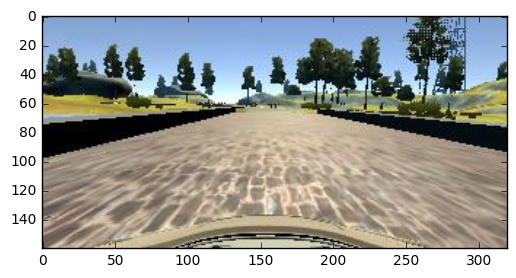

In [3]:
images = []
measurements = []
for line in lines:
    source_path = line[0]
    current_path = main_dir + source_path
    image = mpimg.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)

plt.imshow(images[0])
print(measurements[0])

In [4]:
X_train = np.array(images)
y_train = np.array(measurements)

### Run the model

If model predictions are **poor on both the training and validation set** (for example, mean squared error is high on both), then this is evidence of **underfitting**. Possible solutions could be to
* increase the number of epochs
* add more convolutions to the network.

When the model predicts **well on the training set but poorly on the validation set** (for example, low mean squared error for training set, high mean squared error for validation set), this is evidence of **overfitting**. If the model is overfitting, a few ideas could be to
* use dropout or pooling layers
* use fewer convolution or fewer fully connected layers
* collect more data or further augment the data set

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Activation, Dropout, Input, Dense
from keras.utils import np_utils
from keras.layers import Lambda

**lambda layers** can be used to create arbitrary functions that operate on each image as it passes through the layer.

In this project, a lambda layer is a convenient way to parallelize image normalization. The lambda layer will also ensure that the model will **normalize input images when making predictions in `drive.py`**.

In [15]:
model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Conv2D(32, (3, 3), input_shape=(160, 320, 3)))
model.add(MaxPooling2D((2,2)))
model.add((Dropout(0.5)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 158, 318, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 79, 159, 32)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 79, 159, 32)       0         
_________________________________________________________________
activation_2 (Activation)    (None, 79, 159, 32)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 401952)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               51449984  
__________

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(160, 320,...)`


In [7]:
model.fit(X_train, y_train, validation_split=0.2, shuffle=True)

Train on 6428 samples, validate on 1608 samples
Epoch 1/10
6428/6428 [==============================] - 60s - loss: 0.2441 - val_loss: 0.0167

### Save the model

python drive.py model.h5

In [8]:
model.save(main_dir + "model.h5")

In [9]:
import json
from keras.models import model_from_json

json_string = model.to_json()
with open(main_dir + "model.json", 'w') as outfile:
    json.dump(json.loads(json_string), outfile)

json_string

'{"backend": "tensorflow", "config": [{"config": {"output_shape": null, "name": "lambda_1", "dtype": "float32", "batch_input_shape": [null, 160, 320, 3], "trainable": true, "function_type": "lambda", "function": ["\\u00e3\\u0001\\u0000\\u0000\\u0000\\u0000\\u0000\\u0000\\u0000\\u0001\\u0000\\u0000\\u0000\\u0002\\u0000\\u0000\\u0000C\\u0000\\u0000\\u0000s\\f\\u0000\\u0000\\u0000|\\u0000\\u0000d\\u0001\\u0000\\u001bd\\u0002\\u0000\\u0018S)\\u0003Ng\\u0000\\u0000\\u0000\\u0000\\u0000\\u00e0o@g\\u0000\\u0000\\u0000\\u0000\\u0000\\u0000\\u00e0?\\u00a9\\u0000)\\u0001\\u00da\\u0001xr\\u0001\\u0000\\u0000\\u0000r\\u0001\\u0000\\u0000\\u0000\\u00fa\\u001e<ipython-input-6-977a1834c933>\\u00da\\b<lambda>\\u0003\\u0000\\u0000\\u0000s\\u0000\\u0000\\u0000\\u0000", null, null], "output_shape_type": "raw", "arguments": {}}, "class_name": "Lambda"}, {"config": {"kernel_size": [3, 3], "name": "conv2d_1", "activity_regularizer": null, "dtype": "float32", "padding": "valid", "strides": [1, 1], "batch_inp

### Flipping Images And Steering Measurements
A effective technique for helping with the left turn bias involves flipping images and taking the opposite sign of the steering measurement. For example:

In [32]:
augmented_images, augmented_measurements = [], []

for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1)) #or np.fliplr(image)
    augmented_measurements.append(measurement * -1.0)

augmented_X_train = np.array(augmented_images)
augmented_y_train = np.array(augmented_measurements)

In [34]:
model2 = Sequential()

model2.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model2.add(Conv2D(32, (3, 3), input_shape=(160, 320, 3)))
model2.add(MaxPooling2D((2,2)))
model2.add((Dropout(0.5)))
model2.add(Activation('relu'))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='relu'))

model2.compile(loss='mse', optimizer='adam')

model2.fit(augmented_X_train, augmented_y_train, validation_split=0.2, shuffle=True)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(160, 320,...)`


Train on 12857 samples, validate on 3215 samples
Epoch 1/10
12857/12857 [==============================] - 115s - loss: 0.0166 - val_loss: 0.0167

## Using Multiple Cameras

<img src="carnd-using-multiple-cameras.png" align="right" width="550"/> 

The simulator captures images from three cameras mounted on the car: a **center, right and left camera**. That’s because of the issue of **recovering from being off-center**.

In the simulator, you can weave all over the road and turn recording on and off to record recovery driving. In a real car, however, that’s not really possible. At least not legally.

So in a real car, we’ll have multiple cameras on the vehicle, and we’ll **map recovery paths from each camera**. For example, if you train the model to associate a given image from the center camera with a left turn, then you could also train the model to associate the corresponding image from the left camera with a somewhat softer left turn. And you could train the model to associate the corresponding image from the right camera with an even harder left turn.

In that way, you can **simulate your vehicle being in different positions**, somewhat further off the center line.

From the perspective of the **left camera**, the **steering angle would be less than the steering angle from the center camera**. From the **right camera**'s perspective, the **steering angle would be larger than the angle from the center camera**. The next section will discuss how this can be implemented in your project although there is no requirement to use the left and right camera images.

In [4]:
images_all = images
measurements_all = measurements

correction = 0.2 # this is a parameter to tune

for line in lines:
    left_image = mpimg.imread(main_dir + line[1].strip())
    right_image = mpimg.imread(main_dir + line[2].strip())
    
    steering_center = float(line[3])
    left_measurement = steering_center + correction
    right_measurement = steering_center - correction
    
    images_all.append(left_image)
    measurements_all.append(left_measurement)
    images_all.append(right_image)
    measurements_all.append(right_measurement)

In [5]:
dict_save = {
    "images": images_all,
    "measurements": measurements_all
}
pickle.dump(dict_save, open(main_dir + "dataset_lr.p", "wb"))

In [6]:
dict_load = pickle.load( open(main_dir + "dataset_lr.p", "rb" ) )
images = dict_load["images"]
measurements = dict_load["measurements"]

In [7]:
X_train = np.array(images)
y_train = np.array(measurements)

In [13]:
input_shape = (160,320,3)
kernel_size = (3,3)
depth = (64,32,16,8)
pool_size = (2,2)

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
model.add(Conv2D(depth[0], kernel_size, padding='valid', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(depth[1],kernel_size))
model.add(Activation('relu'))
model.add(Conv2D(depth[2],kernel_size))
model.add(Activation('relu'))
model.add(Conv2D(depth[3],kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 158, 318, 64)      1792      
_________________________________________________________________
activation_8 (Activation)    (None, 158, 318, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 156, 316, 32)      18464     
_________________________________________________________________
activation_9 (Activation)    (None, 156, 316, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 154, 314, 16)      4624      
_________________________________________________________________
activation_10 (Activation)   (None, 154, 314, 16)      0         
__________

In [14]:
model.fit(X_train, y_train, validation_split=0.2, shuffle=True)

Train on 19286 samples, validate on 4822 samples
Epoch 1/10
19286/19286 [==============================] - 597s - loss: 0.0187 - val_loss: 0.0115

In [15]:
model.save(main_dir + "model_lr.h5")

### Cropping Images

The cameras in the simulator capture 160 pixel by 320 pixel images.

Not all of these pixels contain **useful information**, however. In the image above, the **top portion of the image captures trees and hills and sky, and the bottom portion of the image captures the hood of the car**.

Your model might train faster if you crop each image to **focus on only the portion of the image** that is useful for predicting a steering angle.

Keras provides the `Cropping2D` layer for image cropping within the model. This is relatively fast, because the model is **parallelized on the GPU, so many images are cropped simultaneously**.

In [16]:
from keras.layers import Cropping2D

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=input_shape))
model.add(Conv2D(depth[0], kernel_size, padding='valid'))
model.add(Activation('relu'))
model.add(Conv2D(depth[1],kernel_size))
model.add(Activation('relu'))
model.add(Conv2D(depth[2],kernel_size))
model.add(Activation('relu'))
model.add(Conv2D(depth[3],kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 88, 318, 64)       1792      
_________________________________________________________________
activation_15 (Activation)   (None, 88, 318, 64)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 86, 316, 32)       18464     
_________________________________________________________________
activation_16 (Activation)   (None, 86, 316, 32)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 84, 314, 16)       4624      
__________

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True)

Train on 19286 samples, validate on 4822 samples
Epoch 1/10
19286/19286 [==============================] - 330s - loss: 0.0198 - val_loss: 0.0141

In [18]:
model.save(main_dir + "model_lr_cropped.h5")

In [20]:
model.evaluate(X_train, y_train)

24108/24108 [==============================] - 111s        64/24108 [..............................] - ETA: 111s

0.0046880703352865961

### Generators

Generators can be a great way to work with large amounts of data. Instead of storing the preprocessed data in memory all at once, using a generator you can pull pieces of the data and process them on the fly only when you need them, which is much more memory-efficient.

In [39]:
import os
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [40]:
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

In [100]:
def translate_image(image, angle, translation_range = 10):
    rows, cols = image[:,:,1].shape
    tranlation_x = (translation_range * np.random.uniform()) - (translation_range / 2)
    angle_adjusted = angle + (tranlation_x / translation_range * 2 * .2)
    translation_y = (40 * np.random.uniform()) - (40 / 2)
    translation_matrix = np.float32([[1, 0, tranlation_x], [0, 1, translation_y]])
    translated_image = cv2.warpAffine(image, translation_matrix, (cols, rows))
    
    return translated_image, angle_adjusted

In [101]:
def flip_image(image, angle):
    image = cv2.flip(image, 1) #or np.fliplr(image)
    angle = angle * -1.0
    return image, angle


In [102]:
def generator(samples, batch_size=64, correction=0.25):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            draws = np.random.uniform(size=len(batch_samples)) - 0.5
            for i, batch_sample in enumerate(batch_samples):                
                center_image = mpimg.imread(main_dir + batch_sample[0].strip())
                left_image = mpimg.imread(main_dir + batch_sample[1].strip())
                right_image = mpimg.imread(main_dir + batch_sample[2].strip())

                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                
                center_image, center_angle = translate_image(center_image, center_angle)
                left_image, left_angle = translate_image(left_image, left_angle)
                right_image, right_angle = translate_image(right_image, right_angle)
               
                if(draws[i] > 0):
                        center_image, center_angle = flip_image(center_image, center_angle)
                        left_image, left_angle = flip_image(left_image, left_angle)
                        right_image, right_angle = flip_image(right_image, right_angle)

                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [103]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=16)
validation_generator = generator(validation_samples, batch_size=16)

history = model.fit_generator(train_generator,
                              steps_per_epoch = 2 * len(train_samples) // 16,
                              validation_data = validation_generator,
                              validation_steps = 2 * len(validation_samples) // 16,
                              epochs = 5)

Epoch 1/5
803/803 [==============================] - 642s - loss: 0.0297 - val_loss: 0.0206

In [104]:
model.save(main_dir + "model_lr_cropped_generator_jitter.h5")

### Visualizing Loss

In [22]:
from keras.models import load_model
model = load_model(main_dir + 'model_lr_cropped_generator.h5')

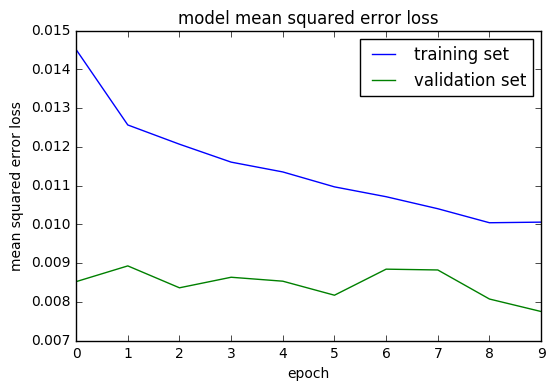

In [57]:
### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()